In [1]:
import skimage.io as io
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import networkx as nx

In [2]:
tiles_path = '/Users/akre96/Data/BE_223B/tiles_rois/normalized/'
centroids_path = '/Users/akre96/Data/BE_223B/tiles_rois/centroids/'

In [3]:
tile_files = os.listdir(tiles_path)
tile_files = [tf for tf in tile_files if tf[0] != '.']

In [4]:
tile_id  = '7664_26880_36736'
#tile_id = tf.split('/')[-1].split('.')[0]
tile = io.imread(os.path.join(tiles_path, tile_id + '.png'))
centroid = pd.read_csv(os.path.join(centroids_path, tile_id + '.csv'))


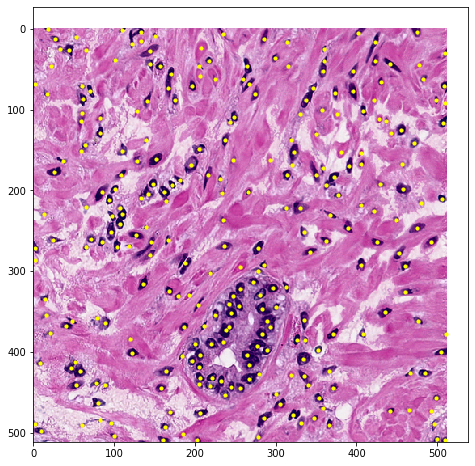

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(tile)
ax.scatter(centroid['x'], centroid['y'], s=10, c='yellow')

In [28]:
from scipy.spatial import distance
import seaborn as sns
dist_matrix = distance.cdist(centroid, centroid)
ft_dist = np.fft.fft2(dist_matrix)
ft_shift = np.fft.fftshift(ft_dist)
ft_dist_mag = np.absolute(ft_shift)

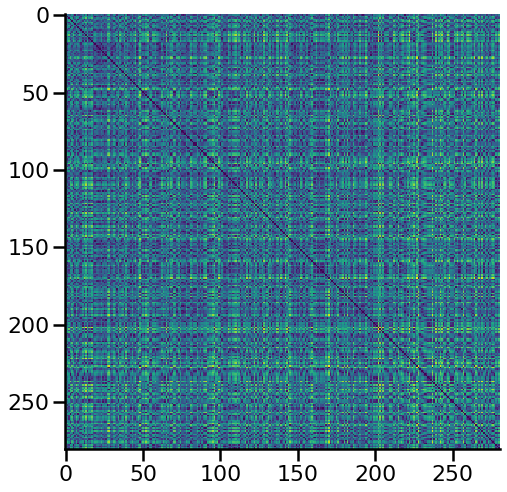

In [27]:
_, ax = plt.subplots(figsize=(8,8))
ax.imshow(dist_matrix);
sns.despine()

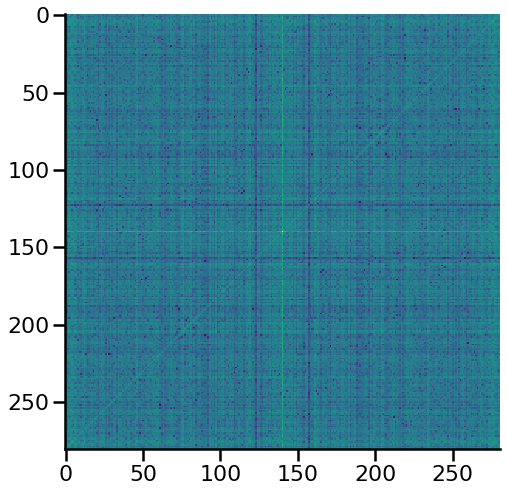

In [32]:
_, ax = plt.subplots(figsize=(8,8))
ax.imshow(np.log(ft_dist_mag));
sns.despine()

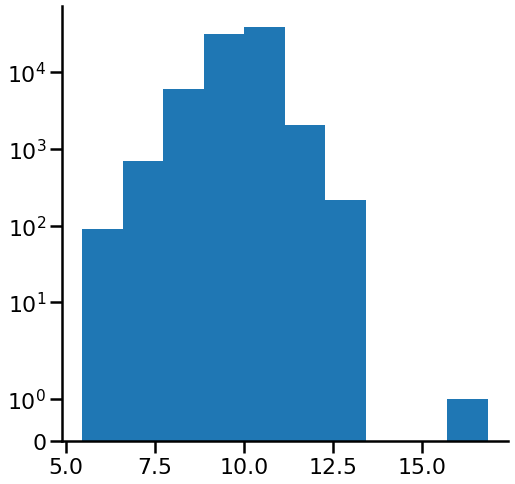

In [35]:
_, ax = plt.subplots(figsize=(8,8))
sns.set_context('poster')
ax.hist(np.log(ft_dist_mag).flatten())
ax.set_yscale('symlog')
sns.despine()

In [78]:
c_list = list(centroid.itertuples(index=False))
c_dict = {
    i: {
        'position': (c_list[i].x, c_list[i].y)
    }
    for i in range(len(c_list))
}


In [79]:

radius = 50
edges = []
edge_dict = {
    'x0': [],
    'y0': [],
    'x1': [],
    'y1': []
}
for cd_0, cd_1 in combinations(c_dict.items(), 2):
    G.add_edge(cd_0[0], cd_1[0])
    c0 = cd_0[1]['position']
    c1 = cd_1[1]['position']
    dist = np.sqrt((c0[0] - c1[0]) ** 2 + (c0[1] - c1[1]) ** 2)

    if dist < radius:
        edge_dict['x0'].append(c0[0])
        edge_dict['y0'].append(c0[1])
        edge_dict['x1'].append(c1[0])
        edge_dict['y1'].append(c1[1])


In [80]:
edges = pd.DataFrame.from_dict(edge_dict)

In [103]:
from sklearn.cluster import KMeans
X = edges[['x0', 'y0', 'x1', 'y1']]
clustering = KMeans().fit(X)

edges['label'] = clustering.labels_
edges.groupby(['label']).count()

x0   y0   x1   y1
label                    
0       88   88   88   88
1      120  120  120  120
2      114  114  114  114
3      346  346  346  346
4      109  109  109  109
5       75   75   75   75
6      118  118  118  118
7      190  190  190  190

In [106]:
colors = [
    '#c23616',
    '#0097e6',
    '#8c7ae6',
    '#718093',
    '#e1b12c',
    '#44bd32',
    '#192a56',
    '#2f3640'
]

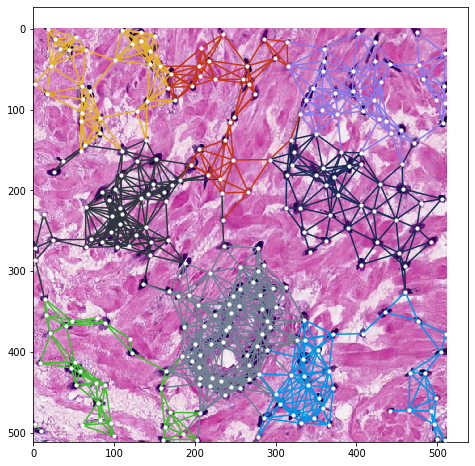

In [111]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(tile)
for i, row in edges.iterrows():
    ax.plot([row.x0, row.x1], [row.y0, row.y1], c=colors[int(row.label)], lw=1.5)
ax.scatter(centroid['x'], centroid['y'], s=10, c='white', zorder=100)


In [133]:
edges.groupby('label').x0.count().sort_values(ascending=False).index[0]

3

In [134]:
largest_cluster = edges.groupby('label').x0.count().sort_values(ascending=False).index[0]
big_clust = edges[edges.label == largest_cluster]
big_clust_0 = big_clust[['x0', 'y0']].rename(columns={'x0': 'x', 'y0': 'y'})
big_clust_1 = big_clust[['x1', 'y1']].rename(columns={'x1': 'x', 'y1': 'y'})
big_clust_nodes = pd.concat([big_clust_0, big_clust_1]).drop_duplicates()

In [136]:
from scipy.spatial import ConvexHull
from matplotlib.path import Path

hull = ConvexHull(big_clust_nodes[['x', 'y']])
print(hull.area, big_clust_nodes.shape[0])

695.0077177791406 64


In [139]:
import graph_metrics_all_slides as gmas
import importlib
importlib.reload(gmas)
features = gmas.kmeans_graph_features_all_slides(tiles_path, centroids_path)

100% (1000 of 1000) |####################| Elapsed Time: 0:05:36 Time:  0:05:36


In [141]:
feature_path = '/Users/akre96/Data/BE_223B/tiles_rois/kmeans_bigclust_features.csv'
features.to_csv(feature_path, index=False)

In [143]:
c_no_c = pd.read_csv('/Users/akre96/Data/BE_223B/tiles_rois/dataset.csv').rename(columns={'tile_name': 'tile'})

c_no_c.head()

slide_id               tile  label
0      3637   3637_81536_41216      1
1      6790   6790_14336_17024      1
2      6427    6427_44800_8960      0
3     12166  12166_22400_30464      0
4      3491  3491_121856_35840      1

In [165]:
dataset = features.merge(c_no_c, how='inner')
dataset['max_clust_density'] = dataset['max_clust_n_nuc']/dataset['max_clust_area']
train = dataset.sample(frac=.8, random_state=1)
test = dataset[~dataset.index.isin(train.index)]

train.head()

tile  n_nuc  max_clust_area  max_clust_n_nuc  slide_id  \
507   7881_86912_25088    119      670.977591               20      7881   
818  12583_86912_10752    309     1209.618892               48     12583   
452   2233_82432_16128    383     1392.741456               57      2233   
368   1833_81536_22400    276      907.420736               34      1833   
242   1440_86912_29568    400     1116.474089               65      1440   

     label  max_clust_density  
507      0           0.029807  
818      0           0.039682  
452      1           0.040926  
368      1           0.037469  
242      0           0.058219

In [166]:
train.columns

Index(['tile', 'n_nuc', 'max_clust_area', 'max_clust_n_nuc', 'slide_id',
       'label', 'max_clust_density'],
      dtype='object')

In [188]:
from sklearn import svm
class_cols = ['n_nuc', 'max_clust_area', 'max_clust_n_nuc']
X = train[class_cols]
y = train['label']

clf = svm.SVC()
clf.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [189]:
test['pred_label'] = clf.predict(test[class_cols])

/Users/akre96/Code/tool_repositories/MoNuSeg/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


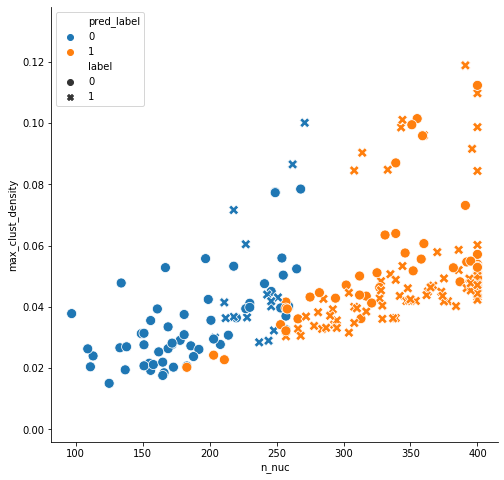

In [190]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,8))
sns.despine()

sns.scatterplot(
    x='n_nuc',
    y='max_clust_density',
    hue='pred_label',
    style='label',
    data=test,
    ax=ax,
    s=100
)

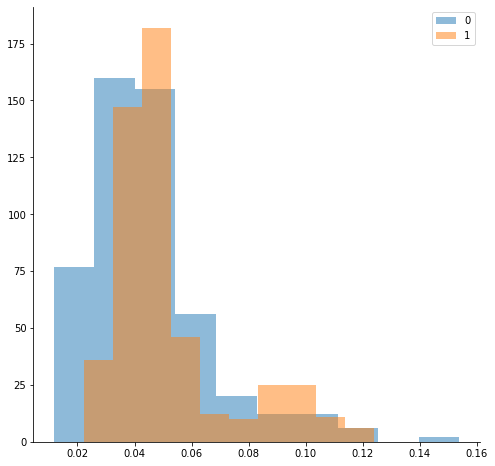

In [191]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
i=0
for label, l_df in dataset.groupby('label'):
    ax.hist(
        l_df.max_clust_density,
        alpha=0.5,
        label=label
    )
    
    sns.despine()
    i+=1

ax.legend()


In [192]:
tp = test[
    (test.pred_label == 1) &
    (test.label == 1)
].shape[0]
tn = test[
    (test.pred_label == 0) &
    (test.label == 0)
].shape[0]
fp = test[
    (test.pred_label == 1) &
    (test.label == 0)
].shape[0]
fn = test[
    (test.pred_label == 0) &
    (test.label == 1)
].shape[0]

In [193]:
sens = tp/(tp+fn)
spec = tn/(tn + fp)
print('Sens:', sens, 'Spec:', spec)

Sens: 0.8383838383838383 Spec: 0.5841584158415841
